In [1]:
import scanpy as sc

In [2]:
import glob
import os
import numpy as np

import seaborn as sns

import pandas as pd
import scipy.stats
import tqdm
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [3]:
import gc

## Read adata

In [4]:
data_path = '/s/project/QNA/scborzoi/submission_data'
motif_path = os.path.join(data_path, 'motif_effects')

In [5]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad'))

## Read ref and alternative

In [6]:
if False:
    alts = pd.Series([x for x in glob.glob('/s/project/semi_supervised_multispecies/Downstream/single_cell/results/motif_deletion/*multiome_fixed.h5ad') if 'ref_multiome' not in x and "atac" not in x and 'rna' not in x])
    
    ad_ref = sc.read(os.path.join(motif_path, 'ref_multiome_fixed.h5ad'))
    
    ad_ref = ad_ref[adata.obs_names]
    
    gene_set_to_run = ad_ref.var_names
    
    median_sf=np.median(ad_ref.X.sum(axis=1))
    
    sc.pp.normalize_total(ad_ref, target_sum=median_sf, key_added='size_factor')
    
    diff_rna = {}
    diff_atac = {}
    norm_factor = ad_ref.obs['size_factor'].values[:, None]
    for i, alt in tqdm.tqdm(enumerate(alts)):
        ad_alt = sc.read(alt)
        motif_name = os.path.basename(alt).split('alt_')[1].split('_multiome_fixed.h5ad')[0]
        ad_alt = ad_alt[adata.obs_names, list(gene_set_to_run)]
    
        ad_alt.X = ad_alt.X/norm_factor * median_sf
    
        motif_rna = (np.log2(ad_ref.X+1) - np.log2(ad_alt.X+1)).mean(axis=1).squeeze()
        diff_rna.update({motif_name: motif_rna})
        del ad_alt
        gc.collect()
    
    diff_rna = pd.DataFrame(diff_rna, index=ad_ref.obs_names)
    diff_rna.columns = diff_rna.columns + '.' + diff_rna.columns
    
    diff_rna.to_parquet(os.path.join(data_path, 'motif_effects', 'diff_rna.pq'))
else:
    diff_rna = pd.read_parquet(os.path.join(data_path, 'motif_effects', 'diff_rna.pq'))

In [59]:
dev = sc.read(os.path.join(data_path, 'motif_effects', 'chromvar', 'deviations.h5ad'))

## Plot overall correlations

In [60]:
dev = dev[diff_rna.index, diff_rna.columns]

In [61]:
new_names_tf = {
    'TYY1': "YY1", 
    'STA5B':"STAT5B",
     'KAISO':"ZBTB33", 
    'STA5A': "STAT5A", 
    'COE1':"EBF1"
}

In [62]:
tf = dev.var_names.str.split('.').str[0].to_list()

In [63]:
tf = pd.Series([tf_i if tf_i not in new_names_tf.keys() else new_names_tf[tf_i] for tf_i in tf])

In [64]:
dev.var['TF'] = tf.values

/scratch/tmp/martensl/ipykernel_1714221/3195176874.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  dev.var['TF'] = tf.values


In [13]:
diff_rna = diff_rna.loc[adata.obs_names]

In [14]:
expression_corr_norm = [scipy.stats.pearsonr(diff_rna[motif].values, adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

In [15]:
expression_chromvar_norm = [scipy.stats.pearsonr(dev[:, motif].X.squeeze(), adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

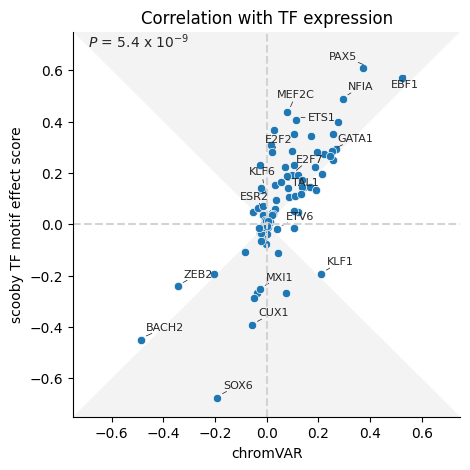

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.scatterplot(x=expression_chromvar_norm, y=expression_corr_norm, ax=ax)

plt.axvline(0, linestyle ='--', color = 'lightgray')
plt.axhline(0, linestyle ='--', color = 'lightgray')

triangle = np.array([[0., 0.], [-1., 1.], [1, 1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

triangle = np.array([[0., 0.], [-1., -1.], [1, -1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

zipped = zip(expression_chromvar_norm, expression_corr_norm)
adj_text = []
for i, (x,y) in enumerate(zipped):
    name= tf.iloc[i]
    if (((x**2 + y**2) > 0.15) and name not in ['CEBPD',  'FOSL2', 'FOSB', 'RUNX2', 'MAFF', 'FOS', 'CREB5', 'KLF2', 'SOX5', 'JDP2', 'TFEC']) or name in ['ESR2', 'KLF6', 'E2F2', 'TAL1', 'MXI1', 'ETV6', 'GATA1', 'E2F7', 'KLF1', 'ZEB2'] : #or str(point['val']) in ['SOX13', 'FOSB', 'TEAD2',  'FLI1', 'FOXP1']:
        if name == 'COE1':
            name = 'EBF1'
        adj_text.append(ax.text(x + 0.01, y+0.01 , "" + f"{name}" +"", size= 8))
adjust_text(adj_text, expand=(2.2, 2.0), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='k', lw = 0.5) # ensure the labeling is clear by adding arrows
            );
ax.text(-0.69,0.69, r'$P$ = 5.4 x $10^{-9}$', size = 10)
#plt.legend([],[], frameon=False)
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.title('Correlation with TF expression')
plt.xlabel("chromVAR")
plt.ylabel("scooby TF motif effect score")
sns.despine()
# plt.savefig('../figures/figures/Figure3/chromVAR_scDogRNA.png',  bbox_inches='tight', dpi = 300)

## scDog RNA only

In [49]:
if False:
    alts = pd.Series([x for x in glob.glob('/s/project/semi_supervised_multispecies/Downstream/single_cell/results/motif_deletion/*rnaonly_fixed.h5ad') if 'ref_rnaonly' not in x and "atac" not in x])
    
    ad_ref = sc.read(os.path.join('/s/project/semi_supervised_multispecies/Downstream/single_cell/results/motif_deletion/ref_rnaonly_fixed.h5ad'))
    
    ad_ref = ad_ref[adata.obs_names]
    
    gene_set_to_run = ad_ref.var_names
    
    median_sf=np.median(ad_ref.X.sum(axis=1))
    
    sc.pp.normalize_total(ad_ref, target_sum=median_sf, key_added='size_factor')
    
    diff_rna = {}
    diff_atac = {}
    norm_factor = ad_ref.obs['size_factor'].values[:, None]
    for i, alt in tqdm.tqdm(enumerate(alts)):
        ad_alt = sc.read(alt)
        motif_name = os.path.basename(alt).split('alt_')[1].split('_rnaonly_fixed.h5ad')[0]
        ad_alt = ad_alt[adata.obs_names, list(gene_set_to_run)]
    
        ad_alt.X = ad_alt.X/norm_factor * median_sf
    
        motif_rna = (np.log2(ad_ref.X+1) - np.log2(ad_alt.X+1)).mean(axis=1).squeeze()
    
        diff_rna.update({motif_name: motif_rna})
        del ad_alt
        gc.collect()
    
    diff_rna = pd.DataFrame(diff_rna, index=ad_ref.obs_names)
    diff_rna.columns = diff_rna.columns + '.' + diff_rna.columns
    
    diff_rna = diff_rna.loc[adata.obs_names]
    
    diff_rna.to_parquet(os.path.join(data_path, 'motif_effects', 'diff_rnaonly.pq'))
else:
    diff_rna = pd.read_parquet(os.path.join(data_path, 'motif_effects', 'diff_rnaonly.pq'))

In [65]:
dev = dev[diff_rna.index, diff_rna.columns]

In [66]:
assert (dev.var_names == diff_rna.columns).all()

In [67]:
expression_corr_norm = [scipy.stats.pearsonr(diff_rna[motif].values, adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

In [68]:
expression_chromvar_norm = [scipy.stats.pearsonr(dev[:, motif].X.squeeze(), adata[:, tf].X.A.squeeze())[0] for motif, tf in zip(dev.var_names, dev.var.TF)]

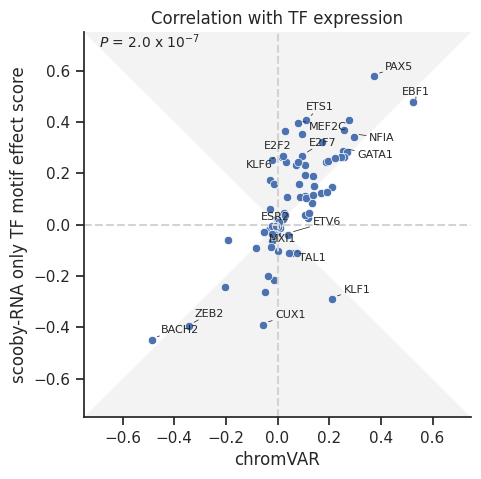

In [69]:
fig, ax = plt.subplots(figsize=(5,5))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.scatterplot(x=expression_chromvar_norm, y=expression_corr_norm, ax=ax)

plt.axvline(0, linestyle ='--', color = 'lightgray')
plt.axhline(0, linestyle ='--', color = 'lightgray')

triangle = np.array([[0., 0.], [-1., 1.], [1, 1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

triangle = np.array([[0., 0.], [-1., -1.], [1, -1]])
polygon = plt.Polygon(triangle, closed=True,alpha=0.25, facecolor='lightgray', edgecolor=None, zorder = -100)
ax.add_patch(polygon)

zipped = zip(expression_chromvar_norm, expression_corr_norm)
adj_text = []
for i, (x,y) in enumerate(zipped):
    name= tf.iloc[i]

    if (((x**2 + y**2) > 0.15) and name not in ['CEBPD',  'FOSL2', 'FOSB', 'RUNX2', 'MAFF', 'FOS', 'CREB5', 'KLF2', 'SOX5', 'JDP2', 'TFEC']) or name in ['ESR2', 'KLF6', 'E2F2', 'TAL1', 'MXI1', 'ETV6', 'GATA1', 'E2F7', 'KLF1', 'ZEB2'] : #or str(point['val']) in ['SOX13', 'FOSB', 'TEAD2',  'FLI1', 'FOXP1']:
        if name == 'COE1':
            name = 'EBF1'
        adj_text.append(ax.text(x + 0.01, y+0.01 , "" + f"{name}" +"", size= 8))
adjust_text(adj_text, expand=(2.2, 1.9), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='k', lw = 0.5) # ensure the labeling is clear by adding arrows
            );

ax.text(-0.69,0.69, r'$P$ = 2.0 x $10^{-7}$', size = 10)
plt.xlim(-0.75,0.75)
plt.ylim(-0.75,0.75)
plt.title('Correlation with TF expression')
plt.xlabel("chromVAR")
plt.ylabel("scooby-RNA only TF motif effect score")
sns.despine()
# plt.savefig('../figures/figures/Figure3/chromVAR_scDogRNA_RNAonly.png',  bbox_inches='tight', dpi = 300)